<a href="https://colab.research.google.com/github/jwdagney55/DSPS_JDagney/blob/main/Labs/PiNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np

In [4]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [5]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2021-12-10 20:16:29--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2021-12-10 20:16:30--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2021-12-10 20:16:30 (8.06 MB/s) - ‘burgers_shock.mat’ saved

(100,) (256,) (256, 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


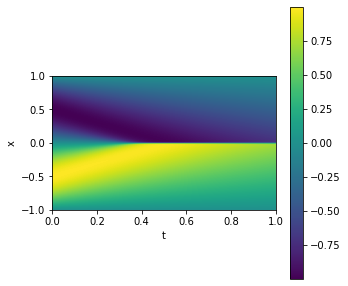

In [8]:
### what is the solution that we want? read in the data
data = scipy.io.loadmat('burgers_shock.mat')
data.keys()
t = data['t'].flatten()
x = data['x'].flatten()
Z = np.real(data['usol'])
print(t.shape, x.shape, Z.shape)
ax = pl.figure(figsize=(5,5)).add_subplot(111)
pl.imshow(Z[::-1],extent=[0,1,-1,1])
ax.set_xlabel("t")
ax.set_ylabel("x");
pl.axes().set_aspect(0.3)
pl.colorbar();

In [9]:
tf.random.set_seed(555)

In [10]:
pi = tf.constant(np.pi, dtype="float32")

In [12]:
#define the boundary condition
def fun_u_0(x):
  return -tf.sin(x*pi)

def fun_u_b(t, x):
  return tf.zeros( (t.shape[0], 1), dtype="float32" )

def fun_res(u, u_t, u_x, u_xx):
  return tf.abs( u_t + u * u_x - 0.01/pi * u_xx )

In [15]:
n_b = 50
n_0 = 50
n_r = 10000
#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

In [16]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        ,  0.7662637 ],
       [ 0.        ,  0.25280237],
       [ 0.        ,  0.5944431 ],
       [ 0.        ,  0.3790462 ],
       [ 0.        ,  0.27760983],
       [ 0.        ,  0.80039334],
       [ 0.        , -0.4731624 ],
       [ 0.        ,  0.96919346],
       [ 0.        , -0.22697711],
       [ 0.        , -0.957886  ],
       [ 0.        , -0.6096263 ],
       [ 0.        , -0.42636728],
       [ 0.        ,  0.5420091 ],
       [ 0.        ,  0.16618752],
       [ 0.        ,  0.203866  ],
       [ 0.        ,  0.31378913],
       [ 0.        , -0.62330437],
       [ 0.        ,  0.59286404],
       [ 0.        , -0.15700698],
       [ 0.        ,  0.37612677],
       [ 0.        ,  0.56657314],
       [ 0.        ,  0.80498147],
       [ 0.        ,  0.47303414],
       [ 0.        ,  0.8809254 ],
       [ 0.        ,  0.136199  ],
       [ 0.        , -0.2665298 ],
       [ 0.        , -0.30301356],
      

In [17]:
u_0 = fun_u_0(x_0)
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[-0.67007077],
       [-0.71330464],
       [-0.956306  ],
       [-0.9286692 ],
       [-0.7657052 ],
       [-0.5867851 ],
       [ 0.9964478 ],
       [-0.09663039],
       [ 0.6541586 ],
       [ 0.1319194 ],
       [ 0.9412778 ],
       [ 0.9733637 ],
       [-0.99130386],
       [-0.49869585],
       [-0.5975675 ],
       [-0.8337128 ],
       [ 0.9259049 ],
       [-0.95774454],
       [ 0.4734927 ],
       [-0.9252284 ],
       [-0.97820866],
       [-0.5750528 ],
       [-0.99641377],
       [-0.36541972],
       [-0.41494447],
       [ 0.74285704],
       [ 0.81454545],
       [ 0.13437958],
       [-0.97866577],
       [ 0.98831105],
       [-0.27295348],
       [-0.707741  ],
       [-0.8877145 ],
       [-0.78507686],
       [-0.81957036],
       [ 0.9985581 ],
       [-0.97480196],
       [ 0.9936506 ],
       [ 0.9251971 ],
       [ 0.99004483],
       [-0.9175083 ],
       [-0.96325666],
       [-0.03116218],
     

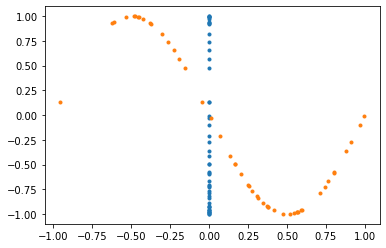

In [21]:
pl.plot(X_0, u_0, '.')

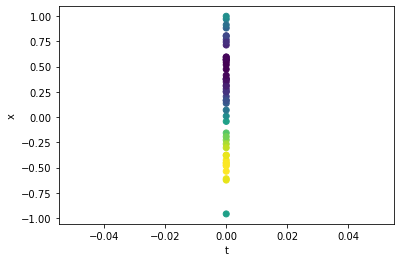

In [22]:
pl.scatter(t_0, x_0, c=u_0, marker='o')
pl.xlabel("t")
pl.ylabel("x");

In [34]:
u_b = fun_u_b(t_b, x_b)

In [33]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype='float32')
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype='float32')
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.35238516, -1.        ],
       [ 0.17862606,  1.        ],
       [ 0.23621058,  1.        ],
       [ 0.93447375,  1.        ],
       [ 0.03084993,  1.        ],
       [ 0.32826388,  1.        ],
       [ 0.39477682, -1.        ],
       [ 0.3588196 , -1.        ],
       [ 0.0662142 ,  1.        ],
       [ 0.5351807 , -1.        ],
       [ 0.17203832, -1.        ],
       [ 0.83192503,  1.        ],
       [ 0.16293132, -1.        ],
       [ 0.8237525 , -1.        ],
       [ 0.7431927 ,  1.        ],
       [ 0.40263462, -1.        ],
       [ 0.9722049 , -1.        ],
       [ 0.7018926 , -1.        ],
       [ 0.7049817 , -1.        ],
       [ 0.08045137,  1.        ],
       [ 0.19442725,  1.        ],
       [ 0.49826145, -1.        ],
       [ 0.62045336,  1.        ],
       [ 0.39029598, -1.        ],
       [ 0.71124613, -1.        ],
       [ 0.46454132, -1.        ],
       [ 0.42329907,  1.        ],
      

In [35]:
pl.plot(t_b, x_b, c=u_b, marker='o')
pl.xlabel("t")
pl.ylabel("x");

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f5e707685f0> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>

In [37]:
t_r = tf.random.uniform( (n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform( (n_r, 1), tmin, tmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[0.03255451, 0.92181206],
       [0.508507  , 0.19056654],
       [0.6472565 , 0.4210366 ],
       ...,
       [0.9173659 , 0.9396814 ],
       [0.7338897 , 0.20379686],
       [0.53214943, 0.0031085 ]], dtype=float32)>

In [38]:
nnmodel = tf.keras.Sequential()

nnmodel.add(tf.keras.Input(2))

for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation="tanh"))


nnmodel.add(tf.keras.layers.Dense(1))

In [39]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(u_pred, u_data):
  return tf.reduce_mean(tf.square(u_data - u_pred))

In [40]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

In [ ]:
history = nnmodel.